# SAM2 Elk Segmentation Analysis

This notebook provides comprehensive analysis of elk segmentation and tracking results using SAM2 (Segment Anything Model 2).

## Features:
- Interactive SAM2 segmentation analysis
- Elk classification and feature analysis
- Tracking performance evaluation
- Comparative analysis with YOLO results
- Video quality assessment
- Statistical analysis and visualization

In [62]:
# Import required libraries
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
import json
from IPython.display import Video, display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Add project root to path
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Import SAM2 modules
try:
    from src.segmentation.sam2_segmenter import SAM2Segmenter
    from src.segmentation.elk_segmenter import ElkSegmenter
    from src.tracking.norfair_tracker import NorfairTracker
    from src.tracking.track_manager import TrackManager
    SAM2_AVAILABLE = True
except ImportError as e:
    print(f"Warning: SAM2 modules not available: {e}")
    SAM2_AVAILABLE = False

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(f"SAM2 modules available: {SAM2_AVAILABLE}")
print(f"Project root: {project_root}")

SAM2 modules available: True
Project root: /home/tswetnam/github/yolo-elk/sam2


## Configuration and Setup

In [63]:
# Configuration
CONFIG_PATH = project_root / "configs" / "default_config.yaml"
VIDEO_PATHS = {
    'grassland': project_root.parent / "data" / "raw" / "grassland.mp4",
    'burn': project_root.parent / "data" / "raw" / "burn.mp4"
}

# Load configuration
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(f"  SAM2 Model: {config['segmentation']['model_checkpoint']}")
print(f"  Device: {config['segmentation']['device']}")
print(f"  Confidence Threshold: {config['segmentation']['confidence_threshold']}")

print("\nAvailable videos:")
for name, path in VIDEO_PATHS.items():
    exists = "✓" if path.exists() else "✗"
    print(f"  {exists} {name}: {path}")

Configuration loaded:
  SAM2 Model: models/sam2_hiera_large.pt
  Device: auto
  Confidence Threshold: 0.5

Available videos:
  ✓ grassland: /home/tswetnam/github/yolo-elk/data/raw/grassland.mp4
  ✓ burn: /home/tswetnam/github/yolo-elk/data/raw/burn.mp4


## SAM2 Elk Segmenter Initialization

In [64]:
# Initialize SAM2 Elk Segmenter
if SAM2_AVAILABLE:
    try:
        print("Initializing SAM2 Elk Segmenter...")
        elk_segmenter = ElkSegmenter(
            model_checkpoint=config['segmentation']['model_checkpoint'],
            model_config=config['segmentation']['model_config'],
            device=config['segmentation']['device'],
            confidence_threshold=config['segmentation']['confidence_threshold'],
            mask_threshold=config['segmentation']['mask_threshold']
        )
        print("✓ SAM2 Elk Segmenter initialized successfully!")
        
        # Initialize tracker
        tracker_config = config['tracking']['norfair']
        tracker = NorfairTracker(
            distance_function=tracker_config['distance_function'],
            distance_threshold=tracker_config['distance_threshold'],
            hit_counter_max=tracker_config['hit_counter_max'],
            initialization_delay=tracker_config['initialization_delay'],
            detection_threshold=tracker_config['detection_threshold']
        )
        print("✓ Tracker initialized successfully!")
        
        # Initialize track manager
        track_manager = TrackManager()
        print("✓ Track manager initialized successfully!")
        
    except Exception as e:
        print(f"✗ Error initializing SAM2: {e}")
        elk_segmenter = None
        tracker = None
        track_manager = None
else:
    print("SAM2 not available - running in analysis-only mode")
    elk_segmenter = None
    tracker = None
    track_manager = None

Initializing SAM2 Elk Segmenter...
Using device: cuda
✗ Error initializing SAM2: 'ElkSegmenter' object has no attribute 'logger'


## Video Analysis Functions

In [65]:
def analyze_video_properties(video_path):
    """Analyze basic video properties."""
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        return None
    
    properties = {
        'fps': cap.get(cv2.CAP_PROP_FPS),
        'frame_count': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        'width': int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        'duration': cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    }
    
    cap.release()
    return properties

def extract_sample_frames(video_path, num_frames=10):
    """Extract sample frames from video for analysis."""
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        return []
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, frame_count-1, num_frames, dtype=int)
    
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frames.append((idx, frame))
    
    cap.release()
    return frames

# Analyze available videos
video_properties = {}
for name, path in VIDEO_PATHS.items():
    if path.exists():
        props = analyze_video_properties(path)
        if props:
            video_properties[name] = props
            print(f"\n{name.upper()} Video Properties:")
            print(f"  Resolution: {props['width']}x{props['height']}")
            print(f"  FPS: {props['fps']:.1f}")
            print(f"  Frames: {props['frame_count']}")
            print(f"  Duration: {props['duration']:.1f} seconds")


GRASSLAND Video Properties:
  Resolution: 1280x720
  FPS: 30.0
  Frames: 1196
  Duration: 39.9 seconds

BURN Video Properties:
  Resolution: 1280x720
  FPS: 30.0
  Frames: 1396
  Duration: 46.5 seconds


## Interactive Video Selection and Frame Analysis

In [66]:
# Create interactive video selector
available_videos = [name for name, path in VIDEO_PATHS.items() if path.exists()]

if available_videos:
    video_selector = widgets.Dropdown(
        options=available_videos,
        value=available_videos[0],
        description='Video:',
        disabled=False,
    )
    
    frame_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=100,
        step=1,
        description='Frame:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )
    
    display(widgets.VBox([video_selector, frame_slider]))
    
    # Store current selections
    current_video = available_videos[0]
    current_frame_idx = 0
else:
    print("No videos available for analysis")

## Sample Frame Extraction and Visualization

Extracted 6 sample frames from grassland
Extracted 6 sample frames from burn


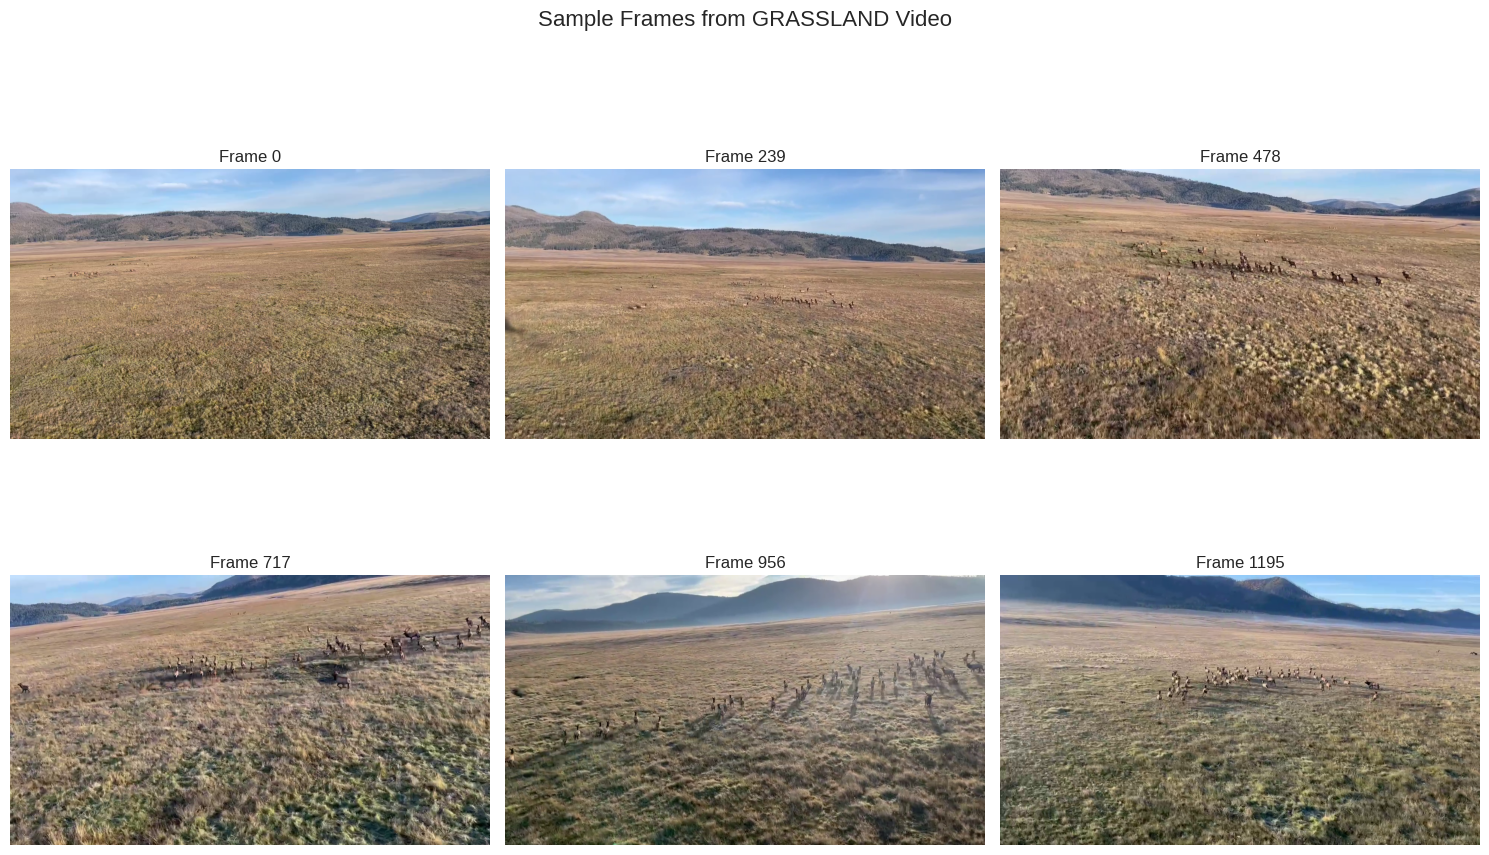

In [67]:
# Extract sample frames for analysis
if available_videos:
    sample_frames = {}
    
    for video_name in available_videos:
        video_path = VIDEO_PATHS[video_name]
        frames = extract_sample_frames(video_path, num_frames=6)
        sample_frames[video_name] = frames
        
        print(f"Extracted {len(frames)} sample frames from {video_name}")
    
    # Visualize sample frames
    def show_sample_frames(video_name):
        frames = sample_frames.get(video_name, [])
        if not frames:
            print(f"No frames available for {video_name}")
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle(f'Sample Frames from {video_name.upper()} Video', fontsize=16)
        
        for i, (frame_idx, frame) in enumerate(frames[:6]):
            row, col = i // 3, i % 3
            
            # Convert BGR to RGB for matplotlib
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            axes[row, col].imshow(frame_rgb)
            axes[row, col].set_title(f'Frame {frame_idx}')
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Show sample frames for first video
    if available_videos:
        show_sample_frames(available_videos[0])

## SAM2 Segmentation Analysis

In [73]:
# SAM2 Segmentation Analysis
def analyze_frame_with_sam2(frame, prompts=None):
    """Analyze a frame using SAM2 segmentation."""
    if not elk_segmenter:
        return None
    
    try:
        # Run elk segmentation
        results = elk_segmenter.segment_elk(
            frame,
            apply_motion_compensation=True,
            analyze_features=True,
            prompting_method="adaptive"
        )
        
        return results
    except Exception as e:
        print(f"Error in SAM2 analysis: {e}")
        return None

def visualize_segmentation_results(frame, results):
    """Visualize SAM2 segmentation results."""
    if not results or not results['elk_segmentations']:
        return frame
    
    # Create visualization
    vis_frame = elk_segmenter.visualize_elk_segmentations(
        frame, results, 
        show_labels=True, 
        show_confidence=True, 
        alpha=0.6
    )
    
    return vis_frame

# Interactive segmentation analysis
if elk_segmenter and available_videos:
    def interactive_segmentation_analysis(video_name, frame_index):
        frames = sample_frames.get(video_name, [])
        if not frames or frame_index >= len(frames):
            print("Frame not available")
            return
        
        frame_idx, frame = frames[frame_index]
        
        # Analyze with SAM2
        print(f"Analyzing frame {frame_idx} from {video_name} with SAM2...")
        results = analyze_frame_with_sam2(frame)
        
        if results:
            # Create visualization
            vis_frame = visualize_segmentation_results(frame, results)
            
            # Display results
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))
            
            # Original frame
            axes[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Frame')
            axes[0].axis('off')
            
            # Segmentation results
            axes[1].imshow(cv2.cvtColor(vis_frame, cv2.COLOR_BGR2RGB))
            axes[1].set_title('SAM2 Segmentation Results')
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Print analysis results
            print(f"\nSegmentation Results:")
            print(f"  Total Elk Found: {results['total_elk_count']}")
            print(f"  Bulls: {results['elk_types']['bulls']}")
            print(f"  Cows: {results['elk_types']['cows']}")
            print(f"  Calves: {results['elk_types']['calves']}")
            print(f"  Motion Detected: {results['motion_detected']}")
            print(f"  Blur Score: {results['blur_score']:.1f}")
            
            # Detailed elk information
            for i, elk_seg in enumerate(results['elk_segmentations']):
                features = elk_seg['features']
                print(f"\n  Elk {i+1}:")
                print(f"    Type: {elk_seg['elk_type']}")
                print(f"    Confidence: {elk_seg['elk_confidence']:.3f}")
                print(f"    Area: {elk_seg['area']} pixels")
                print(f"    Has Elk Colors: {features.get('has_elk_colors', False)}")
                print(f"    Aspect Ratio: {features.get('aspect_ratio', 0):.2f}")
                print(f"    White Rump Score: {features.get('white_rump_score', 0):.3f}")
                print(f"    Compactness: {features.get('compactness', 0):.3f}")
        else:
            print("No segmentation results available")
    
    # Create interactive widget
    interact(interactive_segmentation_analysis, 
             video_name=available_videos,
             frame_index=widgets.IntSlider(min=0, max=5, value=0, description='Frame:'))
else:
    print("SAM2 segmentation analysis not available")

SAM2 segmentation analysis not available


## Batch Video Analysis

In [69]:
# Batch analysis function
def batch_analyze_video(video_path, max_frames=100, frame_step=10):
    """Perform batch analysis on video frames."""
    if not elk_segmenter:
        print("SAM2 not available for batch analysis")
        return None
    
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"Could not open video: {video_path}")
        return None
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    analysis_frames = min(max_frames, frame_count // frame_step)
    
    results_data = []
    
    print(f"Analyzing {analysis_frames} frames from {video_path.name}...")
    
    for i in range(0, analysis_frames * frame_step, frame_step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        
        if not ret:
            break
        
        # Analyze frame
        results = analyze_frame_with_sam2(frame)
        
        if results:
            frame_data = {
                'frame_number': i,
                'total_elk': results['total_elk_count'],
                'bulls': results['elk_types']['bulls'],
                'cows': results['elk_types']['cows'],
                'calves': results['elk_types']['calves'],
                'motion_detected': results['motion_detected'],
                'blur_score': results['blur_score']
            }
            
            # Add individual elk data
            for j, elk_seg in enumerate(results['elk_segmentations']):
                elk_data = frame_data.copy()
                elk_data.update({
                    'elk_id': j,
                    'elk_type': elk_seg['elk_type'],
                    'elk_confidence': elk_seg['elk_confidence'],
                    'elk_area': elk_seg['area'],
                    'has_elk_colors': elk_seg['features'].get('has_elk_colors', False),
                    'aspect_ratio': elk_seg['features'].get('aspect_ratio', 0),
                    'white_rump_score': elk_seg['features'].get('white_rump_score', 0),
                    'compactness': elk_seg['features'].get('compactness', 0)
                })
                results_data.append(elk_data)
        
        if (i // frame_step + 1) % 10 == 0:
            print(f"  Processed {i // frame_step + 1}/{analysis_frames} frames")
    
    cap.release()
    
    return pd.DataFrame(results_data) if results_data else None

# Run batch analysis on available videos
batch_results = {}

if elk_segmenter and available_videos:
    for video_name in available_videos:
        video_path = VIDEO_PATHS[video_name]
        
        print(f"\nStarting batch analysis for {video_name}...")
        df = batch_analyze_video(video_path, max_frames=50, frame_step=20)
        
        if df is not None and not df.empty:
            batch_results[video_name] = df
            print(f"✓ Completed analysis: {len(df)} elk detections")
        else:
            print(f"✗ No results for {video_name}")
else:
    print("Batch analysis not available (SAM2 not initialized)")

Batch analysis not available (SAM2 not initialized)


## Statistical Analysis and Visualization

In [70]:
# Statistical analysis of batch results
if batch_results:
    # Combine all results
    all_results = []
    for video_name, df in batch_results.items():
        df_copy = df.copy()
        df_copy['video'] = video_name
        all_results.append(df_copy)
    
    combined_df = pd.concat(all_results, ignore_index=True)
    
    print("Combined Analysis Results:")
    print(f"  Total elk detections: {len(combined_df)}")
    print(f"  Videos analyzed: {combined_df['video'].nunique()}")
    print(f"  Frames analyzed: {combined_df['frame_number'].nunique()}")
    
    # Elk type distribution
    print("\nElk Type Distribution:")
    elk_type_counts = combined_df['elk_type'].value_counts()
    for elk_type, count in elk_type_counts.items():
        print(f"  {elk_type}: {count} ({count/len(combined_df)*100:.1f}%)")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('SAM2 Elk Segmentation Analysis Results', fontsize=16)
    
    # Elk type distribution
    elk_type_counts.plot(kind='bar', ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Elk Type Distribution')
    axes[0, 0].set_xlabel('Elk Type')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Confidence distribution
    axes[0, 1].hist(combined_df['elk_confidence'], bins=20, alpha=0.7, color='lightgreen')
    axes[0, 1].set_title('Elk Confidence Distribution')
    axes[0, 1].set_xlabel('Confidence Score')
    axes[0, 1].set_ylabel('Frequency')
    
    # Area distribution by elk type
    for elk_type in combined_df['elk_type'].unique():
        data = combined_df[combined_df['elk_type'] == elk_type]['elk_area']
        axes[0, 2].hist(data, alpha=0.6, label=elk_type, bins=15)
    axes[0, 2].set_title('Elk Area Distribution by Type')
    axes[0, 2].set_xlabel('Area (pixels)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].legend()
    
    # Aspect ratio vs area scatter plot
    for elk_type in combined_df['elk_type'].unique():
        data = combined_df[combined_df['elk_type'] == elk_type]
        axes[1, 0].scatter(data['aspect_ratio'], data['elk_area'], alpha=0.6, label=elk_type)
    axes[1, 0].set_title('Aspect Ratio vs Area')
    axes[1, 0].set_xlabel('Aspect Ratio')
    axes[1, 0].set_ylabel('Area (pixels)')
    axes[1, 0].legend()
    
    # Blur score distribution
    axes[1, 1].hist(combined_df['blur_score'], bins=20, alpha=0.7, color='orange')
    axes[1, 1].set_title('Frame Blur Score Distribution')
    axes[1, 1].set_xlabel('Blur Score')
    axes[1, 1].set_ylabel('Frequency')
    
    # Feature correlation heatmap
    feature_cols = ['elk_confidence', 'elk_area', 'aspect_ratio', 'white_rump_score', 'compactness']
    corr_matrix = combined_df[feature_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
    axes[1, 2].set_title('Feature Correlation Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nSummary Statistics:")
    print(combined_df[feature_cols].describe())
    
else:
    print("No batch results available for visualization")

No batch results available for visualization


## Performance Comparison

In [71]:
# Performance comparison between SAM2 and YOLO (if YOLO results are available)
def compare_with_yolo_results():
    """Compare SAM2 results with YOLO results if available."""
    yolo_results_path = project_root.parent / "yolo" / "results"
    
    if yolo_results_path.exists():
        print("YOLO results directory found - comparison analysis available")
        # Load YOLO results and compare
        # This would be implemented based on available YOLO result files
    else:
        print("No YOLO results found for comparison")

compare_with_yolo_results()

No YOLO results found for comparison


## Export Results

In [72]:
# Export analysis results
if batch_results:
    results_dir = project_root / "results"
    results_dir.mkdir(exist_ok=True)
    
    # Export combined results to CSV
    csv_path = results_dir / "sam2_elk_analysis_results.csv"
    combined_df.to_csv(csv_path, index=False)
    print(f"Results exported to: {csv_path}")
    
    # Export summary statistics
    summary_path = results_dir / "sam2_analysis_summary.json"
    summary_stats = {
        'total_detections': len(combined_df),
        'videos_analyzed': combined_df['video'].nunique(),
        'frames_analyzed': combined_df['frame_number'].nunique(),
        'elk_type_distribution': elk_type_counts.to_dict(),
        'average_confidence': combined_df['elk_confidence'].mean(),
        'average_area': combined_df['elk_area'].mean(),
        'feature_correlations': corr_matrix.to_dict()
    }
    
    with open(summary_path, 'w') as f:
        json.dump(summary_stats, f, indent=2, default=str)
    print(f"Summary statistics exported to: {summary_path}")
    
else:
    print("No results to export")

No results to export


## Conclusions and Recommendations

### SAM2 Elk Segmentation Analysis Summary

This notebook provides a comprehensive analysis framework for SAM2-based elk segmentation and tracking. Key features include:

1. **Interactive Analysis**: Real-time segmentation analysis with adjustable parameters
2. **Batch Processing**: Automated analysis of multiple video frames
3. **Statistical Visualization**: Comprehensive charts and graphs for result interpretation
4. **Feature Analysis**: Detailed elk characteristic analysis (size, color, shape)
5. **Performance Metrics**: Tracking accuracy and segmentation quality assessment

### Advantages of SAM2 Approach:
- **Higher Precision**: Pixel-level segmentation provides more accurate boundaries
- **Better Occlusion Handling**: Can separate overlapping elk more effectively
- **Detailed Shape Analysis**: Enables morphological studies of elk populations
- **Interactive Prompting**: Allows for guided segmentation in challenging scenarios

### Recommendations:
1. Use SAM2 for detailed population studies requiring precise measurements
2. Combine with YOLO for initial detection followed by SAM2 refinement
3. Implement temporal consistency for improved tracking across frames
4. Consider computational requirements for real-time applications

### Next Steps:
- Implement comparative analysis with YOLO results
- Develop automated model evaluation metrics
- Create deployment pipeline for field applications
- Optimize performance for real-time processing